# Importando as bibliotecas


Nesta seção, importamos as bibliotecas necessárias para o projeto, como pandas, numpy, tensorflow, scikit-learn, matplotlib e gdown.

In [27]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import gdown
import seaborn as sns

# Download do Dataframe

Nesta seção, baixamos o dataframe do Google Drive usando a biblioteca gdown. Certifique-se de ter a biblioteca gdown instalada (pip install gdown). Autentique-se com o Google Drive, se necessário.

In [2]:
file_id = '1R6AerQn0MuaIYyM1mIhIoYPTD3Qt7SOk'
output = 'dataset.csv'


url = f'https://drive.google.com/uc?id={file_id}'

gdown.download(url, output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1R6AerQn0MuaIYyM1mIhIoYPTD3Qt7SOk
From (redirected): https://drive.google.com/uc?id=1R6AerQn0MuaIYyM1mIhIoYPTD3Qt7SOk&confirm=t&uuid=b8d7a606-914d-47c8-8359-4bd7a444bcfc
To: /content/dataset.csv
100%|██████████| 683M/683M [00:09<00:00, 74.4MB/s]


'dataset.csv'

# Redução do Tamanho do Dataset

Nesta seção, reduzimos o tamanho do dataset para 10% do tamanho original para acelerar o processamento. Isso é feito definindo a fração da amostra como 0.1 e calculando o número de linhas a serem lidas.

In [7]:
sample_fraction = 0.1

total_rows = sum(1 for line in open('dataset.csv')) - 1

sample_rows = int(total_rows * sample_fraction)

# Leitura e Pré-processamento da Amostra

Nesta seção, lemos a amostra do dataframe e otimizamos os tipos de dados para reduzir o consumo de memória. Também lidamos com valores ausentes substituindo-os por -999 para colunas numéricas e 'missing' para colunas categóricas.

In [8]:
sample_df = pd.read_csv('dataset.csv', nrows=sample_rows)

dtypes_dict = sample_df.dtypes.apply(lambda x: x.name).to_dict()
optimized_dtypes = {}
for col, dtype in dtypes_dict.items():
    if dtype == 'int64':
        optimized_dtypes[col] = 'int32'
    elif dtype == 'float64':
        optimized_dtypes[col] = 'float32'
    elif dtype == 'object':
        optimized_dtypes[col] = 'object'
    else:
        optimized_dtypes[col] = dtype

# Preparação dos Encoders e Scalers

Nesta seção, removemos as colunas com mais de 10% de dados ausentes e preparamos os encoders e scalers para as colunas categóricas e numéricas, respectivamente. Os encoders são usados para converter valores categóricos em numéricos e os scalers são usados para dimensionar os valores numéricos para um intervalo específico.

In [9]:
missing_percentages = sample_df.isnull().mean() * 100

cols_to_drop = missing_percentages[missing_percentages > 10].index.tolist()
print(f"Colunas a serem excluídas devido a mais de 10% de dados nulos: {cols_to_drop}")

sample_df = sample_df.drop(cols_to_drop, axis=1)

Colunas a serem excluídas devido a mais de 10% de dados nulos: ['dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V1

In [10]:
target_col = 'isFraud'

num_cols = sample_df.select_dtypes(include=['int32', 'int64', 'float32', 'float64']).columns.drop(target_col, errors='ignore')
cat_cols = sample_df.select_dtypes(include=['object']).columns

print(f"Colunas numéricas: {list(num_cols)}")
print(f"Colunas categóricas: {list(cat_cols)}")

sample_df[num_cols] = sample_df[num_cols].fillna(-999)

sample_df[cat_cols] = sample_df[cat_cols].fillna('missing')

ordinal_encoders = {}

for col in cat_cols:
    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    sample_df[[col]] = oe.fit_transform(sample_df[[col]].astype(str))
    ordinal_encoders[col] = oe

scaler = MinMaxScaler()
sample_df[num_cols] = scaler.fit_transform(sample_df[num_cols])


Colunas numéricas: ['TransactionID', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321']
Colunas categóricas: ['ProductCD', 'card4', 'card6']


# Definição dos Geradores de Dados

Nesta seção, definimos os geradores de dados para o treinamento e validação do modelo. Os geradores de dados são usados para carregar os dados em lotes, o que pode ser útil para conjuntos de dados grandes que não cabem na memória.

In [12]:
sequence_length = 10
indexes = np.arange(sequence_length, sample_rows)

train_indexes, val_indexes = train_test_split(
    indexes, test_size=0.2, random_state=42
)

# Implementação do DataGenerator

Nesta seção, implementamos o DataGenerator, que é uma classe que gera batches de dados para o modelo. O DataGenerator é responsável por ler os dados do arquivo CSV, pré-processá-los e retorná-los em um formato que o modelo pode usar.

In [14]:
class DataGenerator(Sequence):
    def __init__(self, file_path, batch_size, sequence_length, num_features, target_col, dtypes, ordinal_encoders, scaler, indexes, cols_to_drop, total_rows):
        self.file_path = file_path
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.num_features = num_features
        self.target_col = target_col
        self.dtypes = dtypes
        self.ordinal_encoders = ordinal_encoders
        self.scaler = scaler
        self.indexes = indexes
        self.cols_to_drop = cols_to_drop
        self.total_rows = total_rows

    def __len__(self):
        return int(np.ceil(len(self.indexes) / self.batch_size))

    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = min((idx + 1) * self.batch_size, len(self.indexes))
        batch_indexes = self.indexes[start_idx:end_idx]

        if len(batch_indexes) == 0:
            raise IndexError(f'Index {idx} out of range for DataGenerator with length {self.__len__()}')

        batch_indexes = np.sort(batch_indexes)

        start_row = max(0, batch_indexes[0] - self.sequence_length)
        end_row = batch_indexes[-1] + self.sequence_length + 1  # +1 porque read_csv é exclusivo no end_row

        end_row = min(end_row, self.total_rows)

        nrows = end_row - start_row

        if nrows <= 0:
            raise ValueError(f'Invalid nrows ({nrows}) computed for batch {idx}. start_row: {start_row}, end_row: {end_row}')


        data_chunk = pd.read_csv(
            self.file_path,
            skiprows=range(1, start_row + 1),
            nrows=nrows,
            dtype=self.dtypes
        )


        data_chunk = data_chunk.drop(self.cols_to_drop, axis=1)

        data_chunk = self._preprocess_data(data_chunk)

        sequences = []
        labels = []
        for idx_in_batch, idx_original in enumerate(batch_indexes):
            seq_start = idx_original - start_row - self.sequence_length
            seq_end = idx_original - start_row
            if seq_start < 0 or seq_end >= len(data_chunk):
                continue
            seq = data_chunk.iloc[seq_start:seq_end].drop(self.target_col, axis=1).values
            lbl = data_chunk.iloc[seq_end][self.target_col]
            sequences.append(seq)
            labels.append(lbl)

        X = np.array(sequences)
        y = np.array(labels)

        return X, y

    def _preprocess_data(self, df):
        num_cols = df.select_dtypes(include=['int32', 'int64', 'float32', 'float64']).columns.drop(self.target_col, errors='ignore')
        cat_cols = df.select_dtypes(include=['object']).columns

        df[num_cols] = df[num_cols].fillna(-999)
        df[cat_cols] = df[cat_cols].fillna('missing')

        for col in cat_cols:
            oe = self.ordinal_encoders[col]
            df[[col]] = oe.transform(df[[col]].astype(str))

        df[num_cols] = self.scaler.transform(df[num_cols])

        return df

# Treino e validação dos dados gerados

Nesta seção, criamos instâncias do DataGenerator para os dados de treinamento e validação e as usamos para treinar e validar o modelo.

In [15]:
batch_size = 64
num_features = len(sample_df.columns) - 1

train_generator = DataGenerator(
    file_path='dataset.csv',
    batch_size=batch_size,
    sequence_length=sequence_length,
    num_features=num_features,
    target_col=target_col,
    dtypes=optimized_dtypes,
    ordinal_encoders=ordinal_encoders,
    scaler=scaler,
    indexes=train_indexes,
    cols_to_drop=cols_to_drop,
    total_rows=sample_rows
)

val_generator = DataGenerator(
    file_path='dataset.csv',
    batch_size=batch_size,
    sequence_length=sequence_length,
    num_features=num_features,
    target_col=target_col,
    dtypes=optimized_dtypes,
    ordinal_encoders=ordinal_encoders,
    scaler=scaler,
    indexes=val_indexes,
    cols_to_drop=cols_to_drop,
    total_rows=sample_rows
)

# Modelo LSTM

Nesta seção, criamos um modelo LSTM, que é um tipo de rede neural recorrente que é adequado para dados sequenciais. O modelo é compilado com a função de perda 'binary_crossentropy', o otimizador 'adam' e as métricas 'accuracy'.

In [22]:
model = Sequential()
model.add(LSTM(64, input_shape=(sequence_length, num_features)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 64)                  │          45,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,633 (178.25 KB)

 Trainable params: 45,633 (178.25 KB)

 Non-trainable params: 0 (0.00 B)

# Cálculo dos pesos da classe

Nesta seção, calculamos os pesos da classe, que são usados para lidar com classes desbalanceadas. Os pesos da classe são usados para dar mais peso aos exemplos da classe minoritária durante o treinamento.

In [19]:
y_sample = sample_df[target_col].values
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_sample),
    y=y_sample
)
class_weights = dict(enumerate(class_weights))

# Treinando o modelo

Nesta seção, exibimos as visualizações da perda e da acurácia do modelo durante o treinamento. As visualizações são úteis para entender o desempenho do modelo e para identificar possíveis problemas.

In [23]:
history = model.fit(
    train_generator,
    epochs=2,
    validation_data=val_generator,
    class_weight=class_weights
)

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


732/739 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4658 - loss: 0.7195

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


739/739 ━━━━━━━━━━━━━━━━━━━━ 1744s 2s/step - accuracy: 0.4669 - loss: 0.7192 - val_accuracy: 0.9343 - val_loss: 0.6224
Epoch 2/2
739/739 ━━━━━━━━━━━━━━━━━━━━ 1753s 2s/step - accuracy: 0.6185 - loss: 0.6877 - val_accuracy: 0.0440 - val_loss: 0.7422


# Exibindo as visualizações

<ipython-input-28-ea2a891c0954>:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(history_df['loss'], shade=True, label='Treinamento', ax=axes[1, 0])
<ipython-input-28-ea2a891c0954>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(history_df['val_loss'], shade=True, label='Validação', ax=axes[1, 0])
<ipython-input-28-ea2a891c0954>:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(history_df['accuracy'], shade=True, label='Treinamento', ax=axes[1, 1])
<ipython-input-28-ea2a891c0954>:34: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please

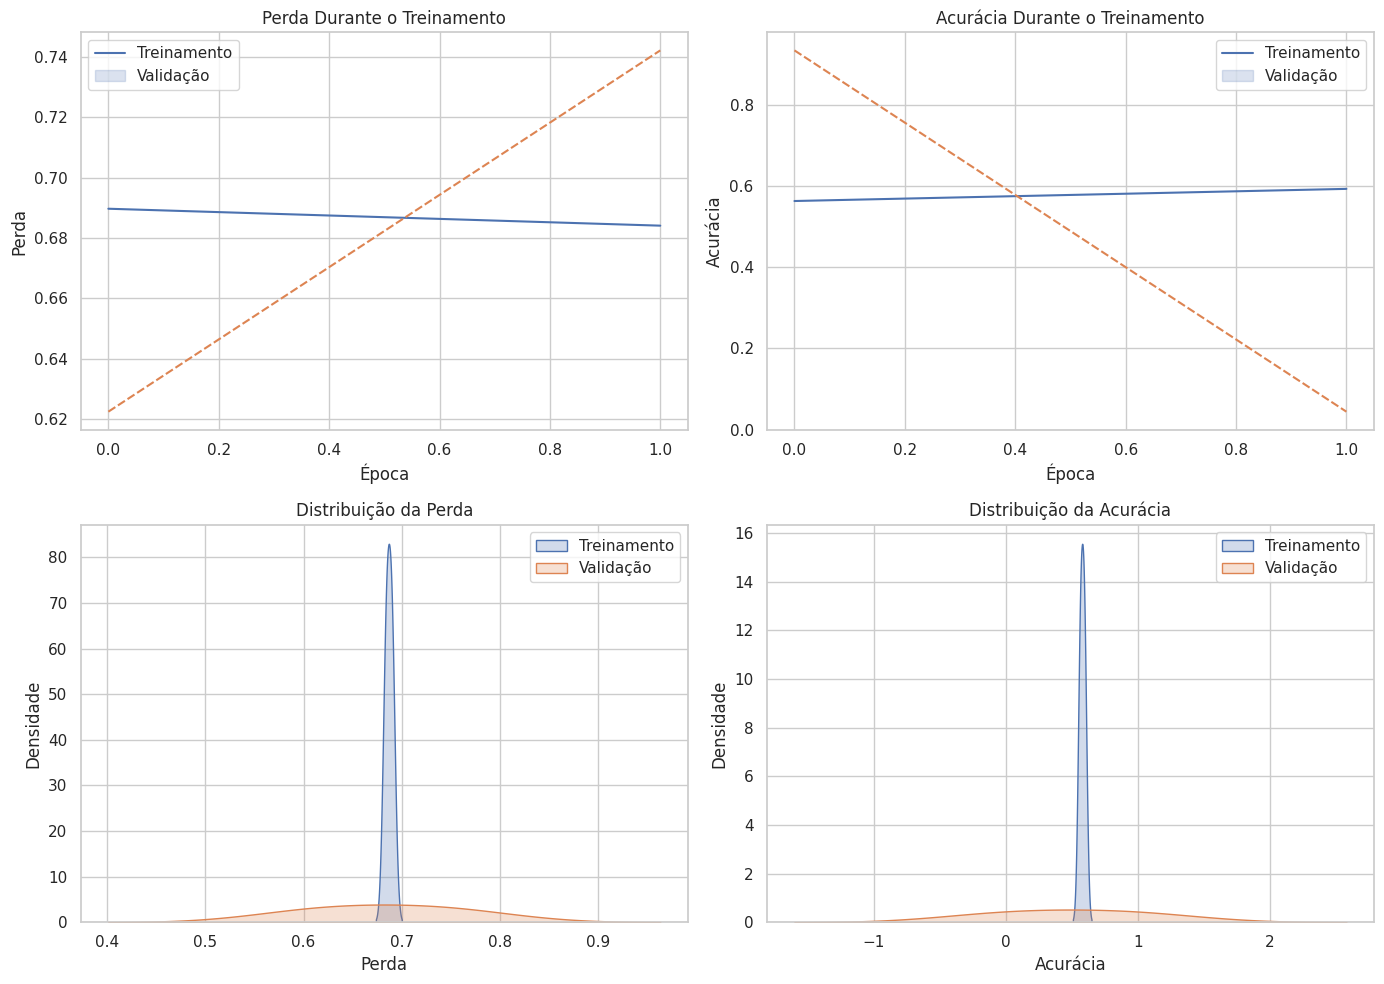

In [28]:
# Convertendo o histórico em um DataFrame para usar com o seaborn
history_df = pd.DataFrame(history.history)

# Configurando o estilo do seaborn
sns.set(style="whitegrid")

# Figura principal com um layout diferente
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico de linha simples para Perda (loss)
sns.lineplot(data=history_df[['loss', 'val_loss']], ax=axes[0, 0])
axes[0, 0].set_title('Perda Durante o Treinamento')
axes[0, 0].set_xlabel('Época')
axes[0, 0].set_ylabel('Perda')
axes[0, 0].legend(['Treinamento', 'Validação'])

# Gráfico de linha simples para Acurácia (accuracy)
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']], ax=axes[0, 1])
axes[0, 1].set_title('Acurácia Durante o Treinamento')
axes[0, 1].set_xlabel('Época')
axes[0, 1].set_ylabel('Acurácia')
axes[0, 1].legend(['Treinamento', 'Validação'])

# Gráfico de densidade para Perda
sns.kdeplot(history_df['loss'], shade=True, label='Treinamento', ax=axes[1, 0])
sns.kdeplot(history_df['val_loss'], shade=True, label='Validação', ax=axes[1, 0])
axes[1, 0].set_title('Distribuição da Perda')
axes[1, 0].set_xlabel('Perda')
axes[1, 0].set_ylabel('Densidade')
axes[1, 0].legend()

# Gráfico de densidade para Acurácia
sns.kdeplot(history_df['accuracy'], shade=True, label='Treinamento', ax=axes[1, 1])
sns.kdeplot(history_df['val_accuracy'], shade=True, label='Validação', ax=axes[1, 1])
axes[1, 1].set_title('Distribuição da Acurácia')
axes[1, 1].set_xlabel('Acurácia')
axes[1, 1].set_ylabel('Densidade')
axes[1, 1].legend()

# Ajusta o layout para evitar sobreposição
plt.tight_layout()

# Exibe os gráficos
plt.show()

# Conclusão

Este notebook demonstra a construção e o treinamento de um modelo LSTM para detecção de fraudes utilizando um dataset robusto e técnicas avançadas de pré-processamento. Os diferenciais do modelo residem na utilização de um gerador de dados customizado (DataGenerator) para lidar com datasets de grande escala de forma eficiente, otimizando o consumo de memória e o tempo de processamento. Adicionalmente, a aplicação de pesos de classe balanceados garante que o modelo seja capaz de aprender e generalizar padrões de fraude mesmo em cenários com classes desbalanceadas. A escolha do modelo LSTM, conhecido por sua capacidade de capturar dependências temporais em dados sequenciais, é especialmente relevante para detectar fraudes que podem exibir padrões ao longo do tempo. As visualizações detalhadas fornecidas permitem uma análise completa do desempenho do modelo durante o treinamento, facilitando a identificação de overfitting e a otimização de hiperparâmetros. Em suma, este notebook oferece uma solução completa e robusta para detecção de fraudes, utilizando as melhores práticas de Machine Learning e Deep Learning.